### План работы:
* [Подключение библиотек и скриптов](#intro)
* [Путь к директориям и файлам](#path)
* [Обозр данных](#overview)
* [Обработка пропусков](#fillna)
* [Обработка выбросов](#outliers)
* [Проверка данных test и train](#testtrain)
* [Построение новых признаков](#new_features)
* [Разбиение на тест и трейн](#test_train_div)
* [Обучение модели](#learning)
* [Прогнозирование и сохранение результатов](#forecasting)
* [Корреляция с базовыми признаками](#correlation)

### Импорт библиотек  <a class='anchor' id='intro'>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)


import featuretools as ft
import featuretools.variable_types as vtypes

from scipy.stats import mannwhitneyu

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings('ignore')

### Путь к директориям и файлам  <a class='anchor' id='path'>

In [2]:
DATASET_TRAIN_PATH = './course_project_train.csv'
PREP_DATASET_TRAIN_PATH = './course_project_train_prep.csv'
DATASET_TEST_PATH = './course_project_test.csv'
PREP_DATASET_TEST_PATH = './course_project_test_prep.csv'

In [3]:
train_df = pd.read_csv(DATASET_TRAIN_PATH)
train_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [4]:
test_df = pd.read_csv(DATASET_TEST_PATH)
test_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

### Обзор данных <a class='anchor' id='overview'>

In [5]:
train_df.shape

(7500, 17)

In [6]:
test_df.shape

(2500, 16)

In [7]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [10]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

#### Обзор целевой переменной

In [11]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [12]:
train_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [13]:
test_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.987000e+03  2500.000000              2500.000000   
mean    1.366922e+06     0.035200                11.184400   
std     9.171252e+05     0.386291                 4.852774   
min     1.065330e+05     0.000000                 1.000000   
25%     8.523115e+05     0.000000                 8.000000   
50%     1.178475e+06     0.000000                10.000000   
75%     1.629734e+06     0.000000                14.000000   
max     1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

#### Обзор номинативных переменных

In [14]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [15]:
for cat_colname in test_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(test_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

### Обработка пропусков <a class='anchor' id='fillna'>

In [16]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [17]:
test_df.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [18]:
def fillna_data(column_list, df, statistic):
    for column in column_list:
        if statistic == 'median':
            df[column].fillna(df[column].median(), inplace=True)
        elif statistic == 'mode':
            df[column].fillna(df[column].mode()[0], inplace=True)
        elif statistic == 'mean':
            df[column].fillna(df[column].mean(), inplace=True)

In [19]:
fillna_data(['Annual Income', 'Credit Score'], train_df, 'median')
train_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
dtype: int64

In [20]:
fillna_data(['Annual Income', 'Credit Score'], test_df, 'median')
test_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
dtype: int64

In [21]:
fillna_data(['Years in current job', 'Bankruptcies' ], train_df, 'mode')
train_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
dtype: int64

In [22]:
fillna_data(['Years in current job', 'Bankruptcies'], test_df, 'mode')
test_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
dtype: int64

In [23]:
replace = (train_df['Months since last delinquent'].isna())

# заменяем значение на рандомное от 0 до 80.
n_1 = train_df['Months since last delinquent'].min()
n_2 = 80
np.random.seed(42)
train_df.loc[replace, 'Months since last delinquent'] = train_df['Months since last delinquent'].apply(lambda x: np.random.randint(n_1, n_2))

In [24]:
replace = (test_df['Months since last delinquent'].isna())

# заменяем значение на рандомное от 0 до 80.
n_1 = test_df['Months since last delinquent'].min()
n_2 = 80
np.random.seed(42)
test_df.loc[replace, 'Months since last delinquent'] = test_df['Months since last delinquent'].apply(lambda x: np.random.randint(n_1, n_2))

### Обработка выбросов <a class='anchor' id='outliers'>

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

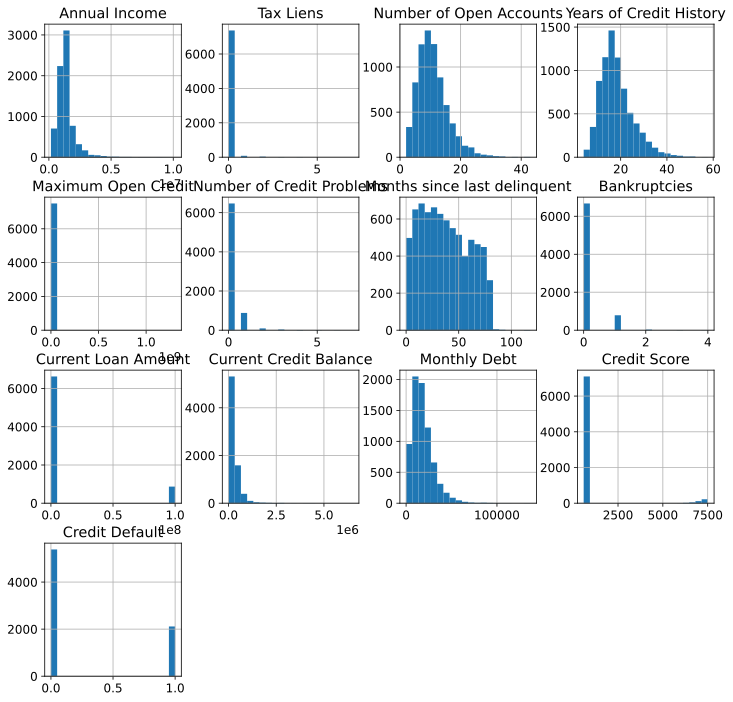

In [25]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

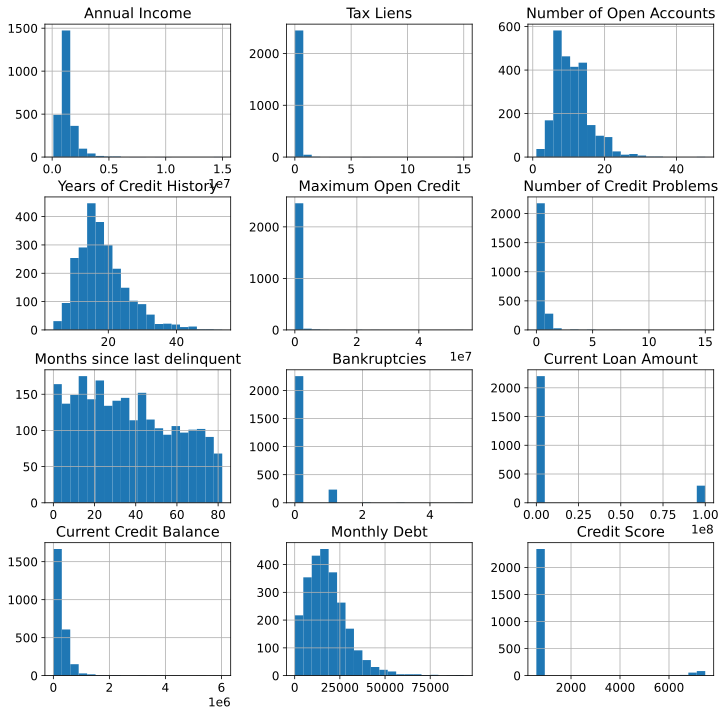

In [26]:
df_num_features = test_df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

In [27]:
def outliers_replacement(column, threshold, df, metric):
    if metric == 'median':
        df.loc[df[column] > threshold, column] = df[column].median()
    elif metric == 'mode':
        df.loc[df[column] > threshold, column] = df[column].mode()[0]
    elif metric == 'mean':
        df.loc[df[column], column] = df[column].mean()

#### Annual Income

<AxesSubplot:>

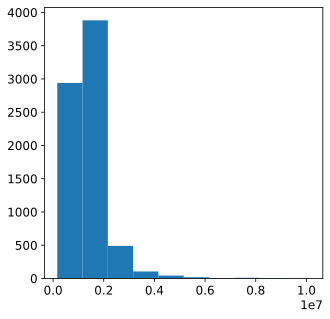

In [28]:
train_df['Annual Income'].hist(figsize=(5,5), bins=10, grid=False)

In [29]:
train_df.loc[train_df['Annual Income'] > 6000000, 'Annual Income'].count()

26

<AxesSubplot:>

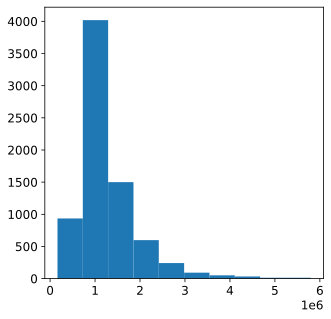

In [30]:
outliers_replacement('Annual Income', 6000000, train_df, 'median')
train_df['Annual Income'].hist(figsize=(5,5), bins=10, grid=False)

<AxesSubplot:>

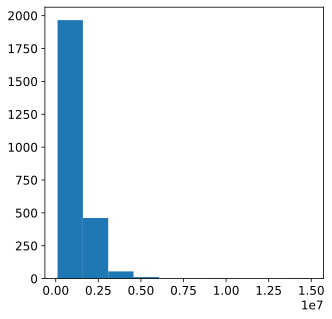

In [31]:
test_df['Annual Income'].hist(figsize=(5,5), bins=10, grid=False)

<AxesSubplot:>

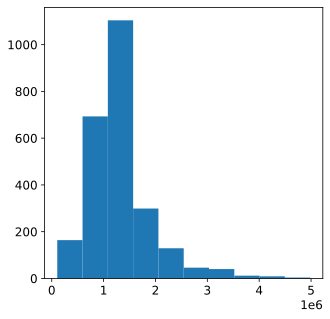

In [32]:
outliers_replacement('Annual Income', 5000000, test_df, 'median')
test_df['Annual Income'].hist(figsize=(5,5), bins=10, grid=False)

#### Tax Liens

<AxesSubplot:>

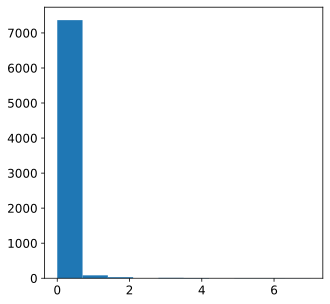

In [33]:
train_df['Tax Liens'].hist(figsize=(5,5), bins=10, grid=False)

In [34]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [35]:
outliers_replacement('Tax Liens', 2, train_df, 'mode')

<AxesSubplot:>

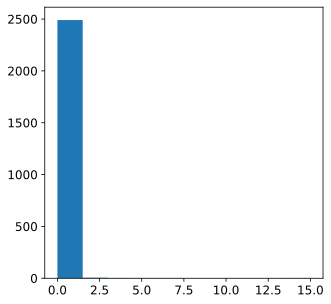

In [36]:
test_df['Tax Liens'].hist(figsize=(5,5), bins=10, grid=False)

In [37]:
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

In [38]:
outliers_replacement('Tax Liens', 2, test_df, 'mode')

#### Current Loan Amount

<AxesSubplot:>

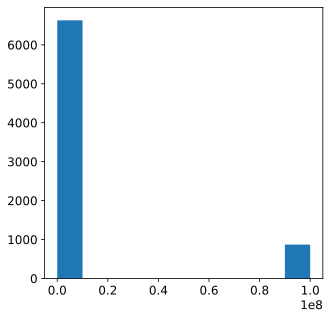

In [39]:
train_df['Current Loan Amount'].hist(figsize=(5,5), bins=10, grid=False)

In [40]:
train_df.loc[train_df['Current Loan Amount']>80000000, 'Current Loan Amount'].value_counts()

99999999.0    870
Name: Current Loan Amount, dtype: int64

<AxesSubplot:>

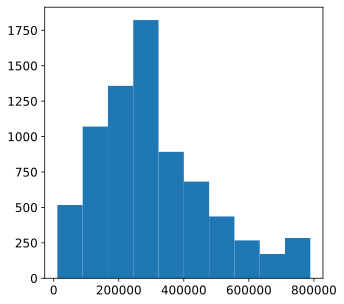

In [41]:
outliers_replacement('Current Loan Amount', 80000000, train_df, 'median')
train_df['Current Loan Amount'].hist(figsize=(5,5), bins=10, grid=False)

<AxesSubplot:>

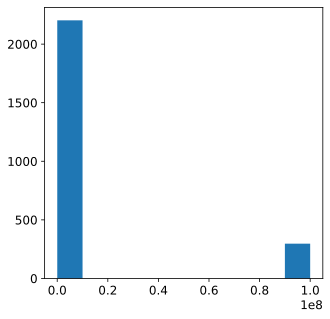

In [42]:
test_df['Current Loan Amount'].hist(figsize=(5,5), bins=10, grid=False)

In [43]:
test_df.loc[train_df['Current Loan Amount']>80000000, 'Current Loan Amount'].value_counts()

Series([], Name: Current Loan Amount, dtype: int64)

<AxesSubplot:>

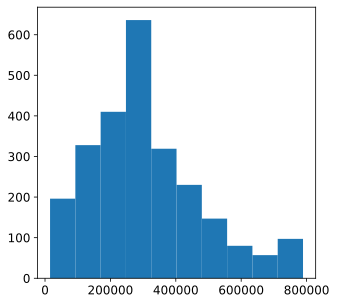

In [44]:
outliers_replacement('Current Loan Amount', 80000000, test_df, 'median')
test_df['Current Loan Amount'].hist(figsize=(5,5), bins=10, grid=False)

#### Number of Open Accounts

<AxesSubplot:>

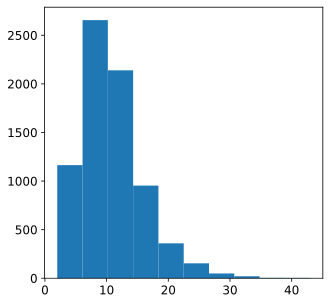

In [45]:
train_df['Number of Open Accounts'].hist(figsize=(5,5), bins=10, grid=False)

In [46]:
outliers_replacement('Number of Open Accounts', 30, train_df, 'mode')

<AxesSubplot:>

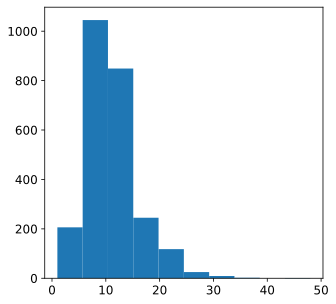

In [47]:
test_df['Number of Open Accounts'].hist(figsize=(5,5), bins=10, grid=False)

In [48]:
outliers_replacement('Number of Open Accounts', 30, test_df, 'mode')

#### Years of Credit History

In [49]:
def columns_hist(column, df):
    df[column].hist(figsize=(5,5), bins=10, grid=False)

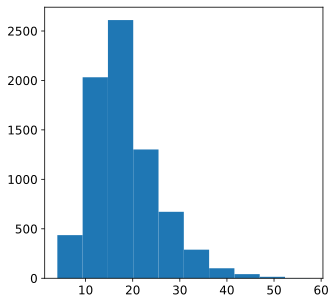

In [50]:
columns_hist('Years of Credit History', train_df)

In [51]:
train_df.loc[train_df['Years of Credit History'] > 40,'Years of Credit History'].count()

83

In [52]:
outliers_replacement('Years of Credit History', 40, train_df, 'mode')

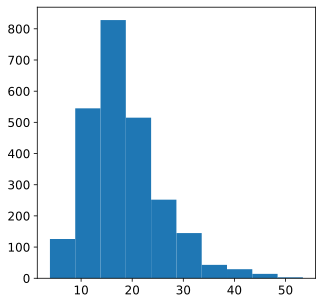

In [53]:
columns_hist('Years of Credit History', test_df)

In [54]:
outliers_replacement('Years of Credit History', 40, test_df, 'mode')

#### Maximum Open Credit

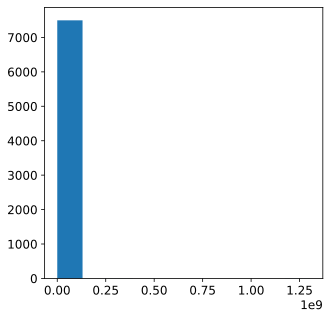

In [55]:
columns_hist('Maximum Open Credit', train_df)

In [56]:
outliers_replacement('Maximum Open Credit', 3000000, train_df, 'median')

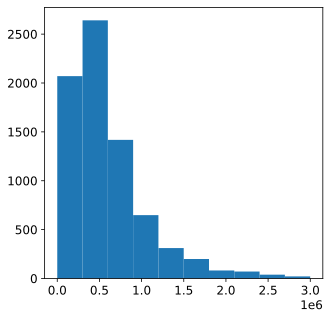

In [57]:
columns_hist('Maximum Open Credit', train_df)

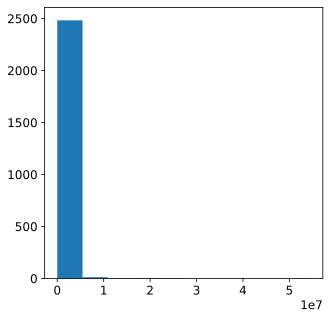

In [58]:
columns_hist('Maximum Open Credit', test_df)

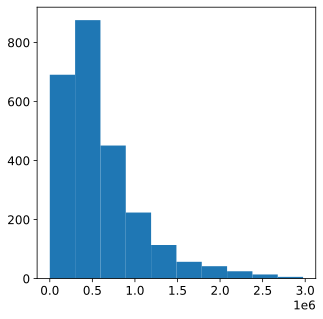

In [59]:
outliers_replacement('Maximum Open Credit', 3000000, test_df, 'median')
columns_hist('Maximum Open Credit', test_df)

#### Number of Credit Problems

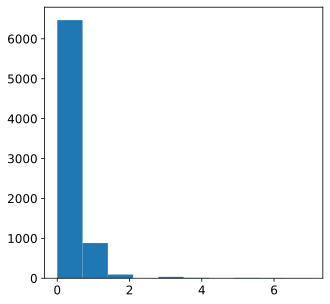

In [60]:
columns_hist('Number of Credit Problems', train_df)

In [61]:
train_df.loc[train_df['Number of Credit Problems'] > 3, 'Number of Credit Problems'].count()

21

In [62]:
outliers_replacement('Number of Credit Problems', 3, train_df, 'mode')

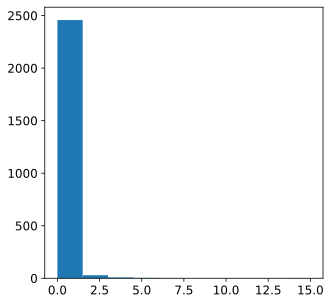

In [63]:
columns_hist('Number of Credit Problems', test_df)

In [64]:
outliers_replacement('Number of Credit Problems', 3, test_df, 'mode')

#### Months since last delinquent

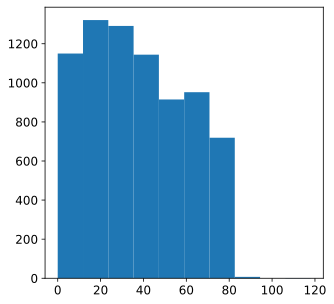

In [65]:
columns_hist('Months since last delinquent', train_df)

In [66]:
train_df.loc[train_df['Months since last delinquent'] > 80, 'Months since last delinquent'].count()

31

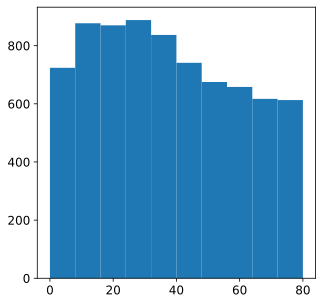

In [67]:
outliers_replacement('Months since last delinquent', 80, train_df, 'mode')
columns_hist('Months since last delinquent', train_df)

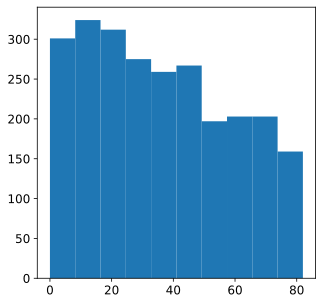

In [68]:
columns_hist('Months since last delinquent', test_df)

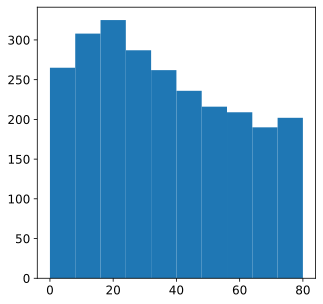

In [69]:
outliers_replacement('Months since last delinquent', 80, test_df, 'mode')
columns_hist('Months since last delinquent', test_df)

#### Bankruptcies

#### Current Credit Balance

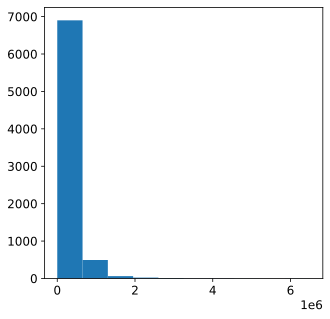

In [70]:
columns_hist('Current Credit Balance', train_df)

In [71]:
train_df.loc[train_df['Current Credit Balance'] > 1500000, 'Current Credit Balance'].count()

74

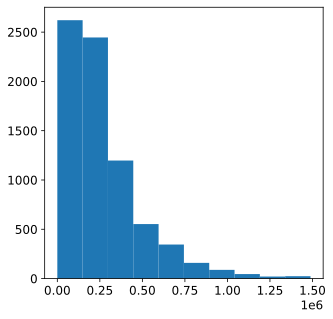

In [72]:
outliers_replacement('Current Credit Balance', 1500000, train_df, 'median')
columns_hist('Current Credit Balance', train_df)

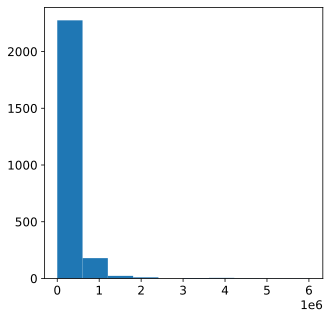

In [73]:
columns_hist('Current Credit Balance', test_df)

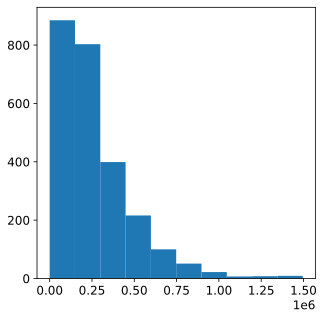

In [74]:
outliers_replacement('Current Credit Balance', 1500000, test_df, 'median')
columns_hist('Current Credit Balance', test_df)

#### Monthly Debt

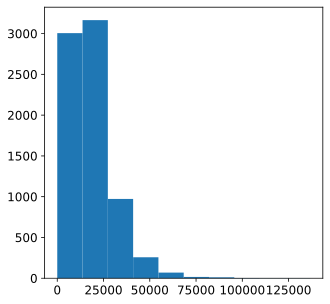

In [75]:
columns_hist('Monthly Debt', train_df)

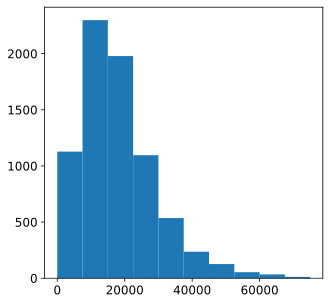

In [76]:
outliers_replacement('Monthly Debt', 75000, train_df, 'median')
columns_hist('Monthly Debt', train_df)

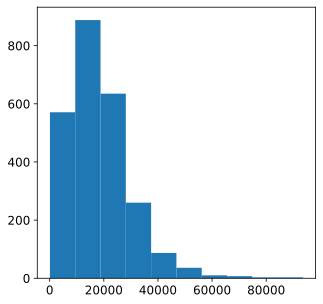

In [77]:
columns_hist('Monthly Debt', test_df)

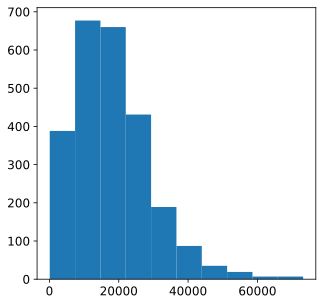

In [78]:
outliers_replacement('Monthly Debt', 75000, test_df, 'median')
columns_hist('Monthly Debt', test_df)

#### Credit Score

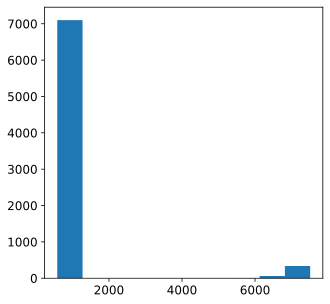

In [79]:
columns_hist('Credit Score', train_df)

In [80]:
train_df.loc[train_df['Credit Score'] > 2000, 'Credit Score'].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

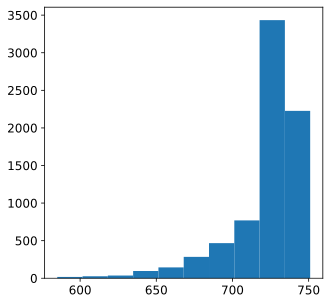

In [81]:
outliers_replacement('Credit Score', 2000, train_df, 'mode')
columns_hist('Credit Score', train_df)

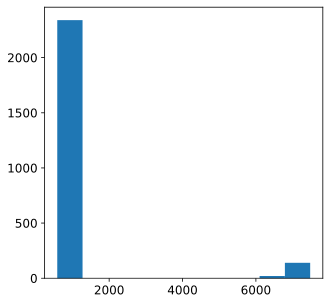

In [82]:
columns_hist('Credit Score', test_df)

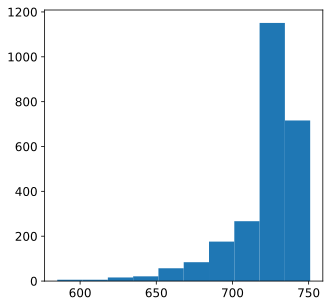

In [83]:
outliers_replacement('Credit Score', 2000, test_df, 'mode')
columns_hist('Credit Score', test_df)

#### Проверка признаков после обработки выбросов и пропусков

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

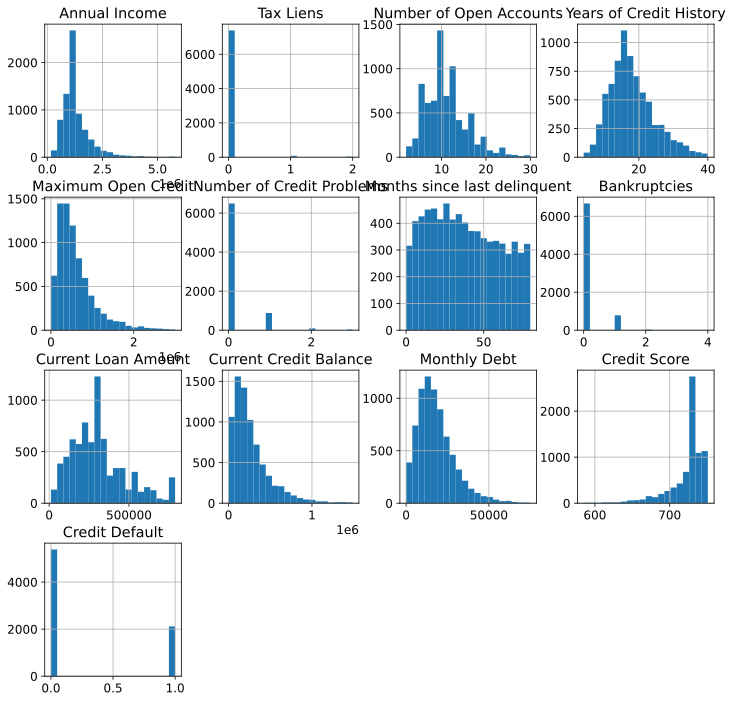

In [84]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

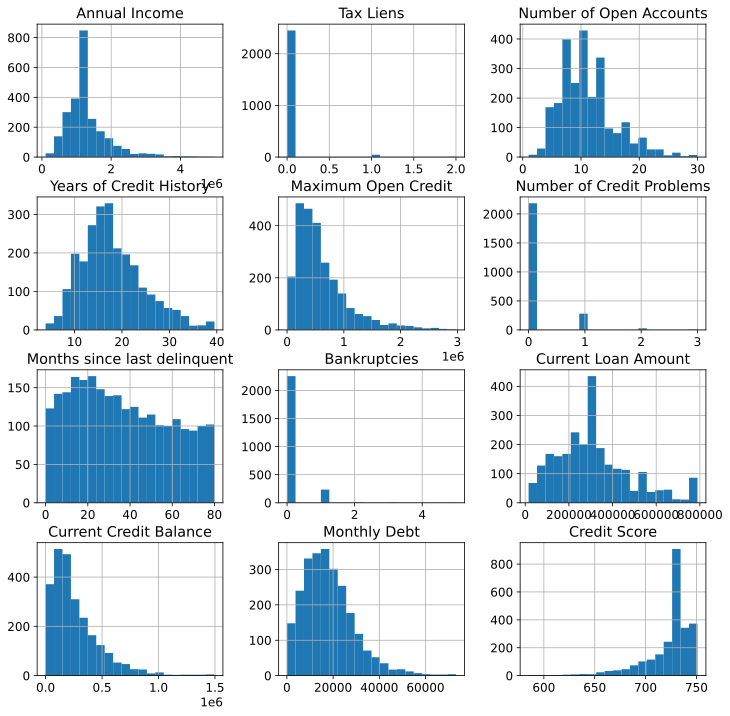

In [85]:
df_num_features = test_df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

### Проверка данных Test и Train <a class='anchor' id='testtrain'>

#### Проверка распределения вещественных признаков на трейне и на тесте

Annual Income
MannwhitneyuResult(statistic=8949760.5, pvalue=0.0003262777228747811)


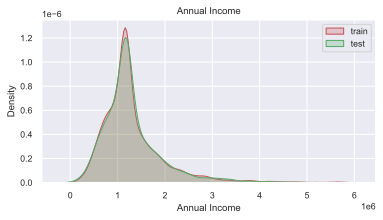

Number of Open Accounts
MannwhitneyuResult(statistic=9264740.0, pvalue=0.18827083388924226)


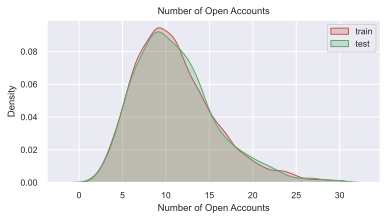

Years of Credit History
MannwhitneyuResult(statistic=9337023.0, pvalue=0.3806387159424527)


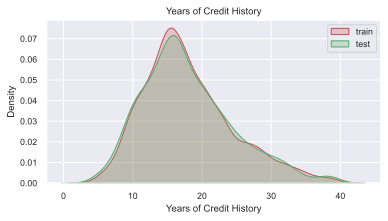

Maximum Open Credit
MannwhitneyuResult(statistic=9355683.5, pvalue=0.4385997178325911)


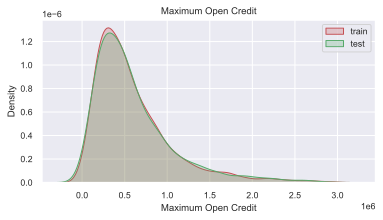

Number of Credit Problems
MannwhitneyuResult(statistic=9295274.0, pvalue=0.13906287715775756)


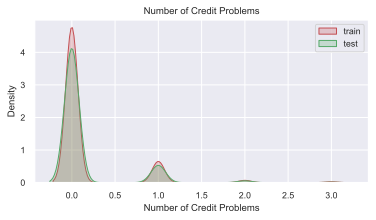

Number of Open Accounts
MannwhitneyuResult(statistic=9264740.0, pvalue=0.18827083388924226)


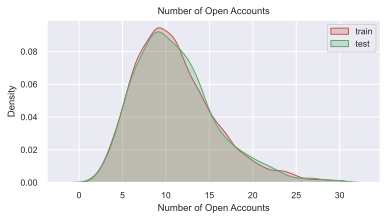

Tax Liens
MannwhitneyuResult(statistic=9329217.5, pvalue=0.04747835879426789)


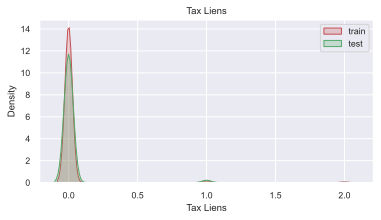

Months since last delinquent
MannwhitneyuResult(statistic=9101729.5, pvalue=0.014399090327276742)


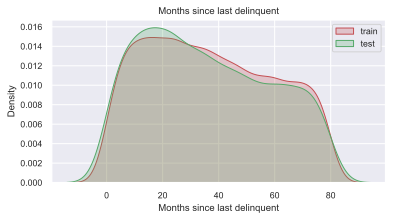

Bankruptcies
MannwhitneyuResult(statistic=9260973.0, pvalue=0.04432950519761078)


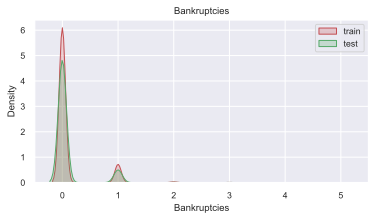

Current Loan Amount
MannwhitneyuResult(statistic=9048498.5, pvalue=0.004490558789771227)


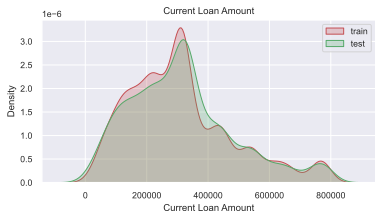

Current Credit Balance
MannwhitneyuResult(statistic=9314936.0, pvalue=0.315441587071239)


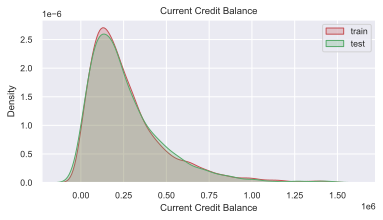

Monthly Debt
MannwhitneyuResult(statistic=9282422.0, pvalue=0.22947316573788112)


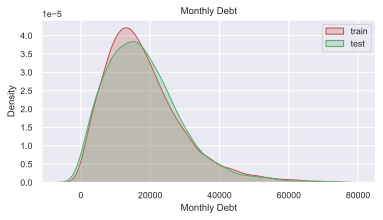

Credit Score
MannwhitneyuResult(statistic=9247418.5, pvalue=0.15114281548880665)


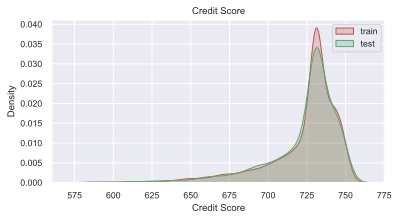

In [86]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                    'Number of Credit Problems', 'Number of Open Accounts', 'Tax Liens', 'Months since last delinquent',
                    'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

#### Проверка распределения категориальных признаков на трейне и на тесте

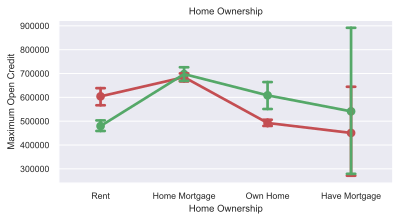

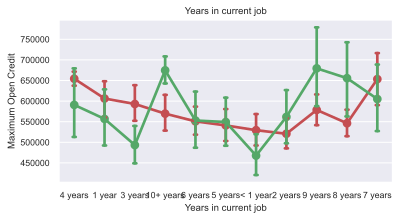

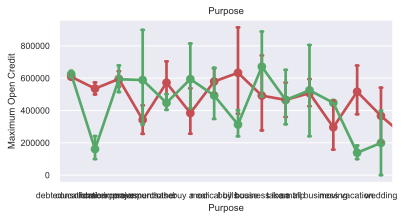

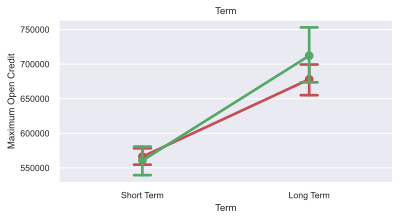

In [87]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
num_feature = 'Maximum Open Credit'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

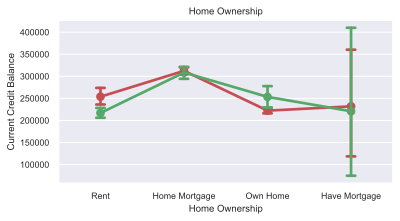

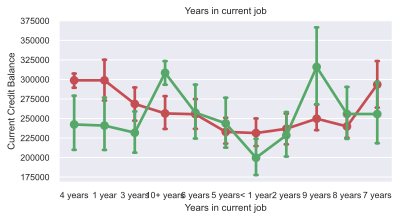

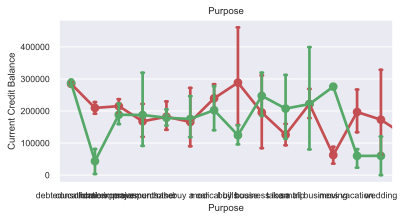

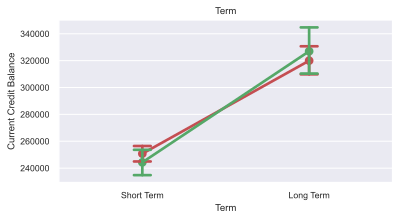

In [88]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

### Построение новых признаков <a class='anchor' id='new_features'>

#### Преобразование переменной Years in current job

In [89]:
train_df['Years_in_current job'] = train_df['Years in current job'].map({'10+ years':'10', '2 years':'2', '3 years':'3', \
                                                                 '< 1 year': '0', '5 years':'5', '1 year':'1', \
                                                                 '4 years':'4', '6 years':'6', '7 years':'7', \
                                                                 '8 years':'8', '9 years':'9'}).astype(int)

In [90]:
test_df['Years_in_current job'] = test_df['Years in current job'].map({'10+ years':'10', '2 years':'2', '3 years':'3', \
                                                                 '< 1 year': '0', '5 years':'5', '1 year':'1', \
                                                                 '4 years':'4', '6 years':'6', '7 years':'7', \
                                                                 '8 years':'8', '9 years':'9'}).astype(int)

#### Преобразование переменной Purpose

In [91]:
for i in train_df['Purpose'].unique():
    if train_df.loc[train_df['Purpose']==i, 'Purpose'].value_counts()[0] < 70:
        train_df.loc[train_df['Purpose']==i, 'Purpose'] = 'other'

train_df['Purpose'].value_counts()
    

debt consolidation    5944
other                  848
home improvements      412
business loan          129
buy a car               96
medical bills           71
Name: Purpose, dtype: int64

In [92]:
for i in test_df['Purpose'].unique():
    if test_df.loc[test_df['Purpose']==i, 'Purpose'].value_counts()[0] < 20:
        test_df.loc[test_df['Purpose']==i, 'Purpose'] = 'other'

test_df['Purpose'].value_counts()

debt consolidation    1973
other                  296
home improvements      140
buy a car               34
business loan           30
medical bills           27
Name: Purpose, dtype: int64

#### Создание дамми-переменных

In [93]:
for cat_colname in train_df.select_dtypes(include='object').columns[0:]:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7500 non-null   object 
 1   Annual Income                   7500 non-null   float64
 2   Years in current job            7500 non-null   object 
 3   Tax Liens                       7500 non-null   float64
 4   Number of Open Accounts         7500 non-null   float64
 5   Years of Credit History         7500 non-null   float64
 6   Maximum Open Credit             7500 non-null   float64
 7   Number of Credit Problems       7500 non-null   float64
 8   Months since last delinquent    7500 non-null   float64
 9   Bankruptcies                    7500 non-null   float64
 10  Purpose                         7500 non-null   object 
 11  Term                            7500 non-null   object 
 12  Current Loan Amount             75

In [95]:
for cat_colname in test_df.select_dtypes(include='object').columns[0:]:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[cat_colname], prefix=cat_colname)], axis=1)

In [96]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  2500 non-null   object 
 1   Annual Income                   2500 non-null   float64
 2   Years in current job            2500 non-null   object 
 3   Tax Liens                       2500 non-null   float64
 4   Number of Open Accounts         2500 non-null   float64
 5   Years of Credit History         2500 non-null   float64
 6   Maximum Open Credit             2500 non-null   float64
 7   Number of Credit Problems       2500 non-null   float64
 8   Months since last delinquent    2500 non-null   float64
 9   Bankruptcies                    2500 non-null   float64
 10  Purpose                         2500 non-null   object 
 11  Term                            2500 non-null   object 
 12  Current Loan Amount             25

#### Feature encoding and Feature discretization

Функция для feature encoding

In [97]:
def feature_encode(cat_column,target_column, statistic):
    global df_cat, train_df, test_df
    if statistic == 'mean':
        df_cat = train_df.groupby(cat_column, as_index=False).mean()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_'+\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')
    elif statistic == 'median':
        df_cat = train_df.groupby(cat_column, as_index=False).median()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_' +\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')
        
    elif statistic == 'sum':
        df_cat = train_df.groupby(cat_column, as_index=False).sum()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_' +\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')
    elif statistic == 'count':
        df_cat = train_df.groupby(cat_column, as_index=False).count()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_' +\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')
    elif statistic == 'max':
        df_cat = train_df.groupby(cat_column, as_index=False).max()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_'+\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')
    elif statistic == 'min':
        df_cat = train_df.groupby(cat_column, as_index=False).min()[[cat_column, target_column]].rename(columns=\
                                                                                                  {target_column: \
                                                                                                  target_column + '_' +\
                                                                                                  cat_column + '_' +\
                                                                                                  statistic})
        df_cat = pd.DataFrame(df_cat)
        train_df = train_df.merge(df_cat, on=cat_column, how='left')
        test_df = test_df.merge(df_cat, on=cat_column, how='left')

In [98]:
feature_encode('Years in current job_10+ years', 'Annual Income', 'mean')
feature_encode('Number of Open Accounts', 'Credit Score', 'mean')
train_df

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0            10+ years        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
...             ...            ...                  ...        ...   
7495           Rent       402192.0             < 1 year        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   
7497           Rent      1878910.0              6 years        0.0   
7498  Home Mortgage      1168386.0            10+ years        0.0   
7499           Rent      1168386.0              4 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                          51.0           1.0   
1                           0.0                          14.0           0.0   
2                           0.0                          71.0           0.0   
3                           1.0                          60.0           1.0   
4                           1.0                          20.0           0.0   
...                         ...                           ...           ...   
7495                        0.0                          65.0           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                          32.0           0.0   
7498                        0.0                          38.0           0.0   
7499                        0.0                          45.0           0.0   

      ... Purpose_business loan Purpose_buy a car  Purpose_debt consolidation  \
0     ...                     0                 0                           1   
1     ...                     0                 0                           1   
2     ...                     0                 0                           1   
3     ...                     0                 0                           1   
4     ...                     0                 0                           1   
...   ...                   ...               ...                         ...   
7495  ...                     0                 0                           0   
7496  ...                     0                 0                           1   
7497  ...                     0                 1                           0   
7498  ...                     0                 0                           1   
7499  ...                     0                 0                           1   

      Purpose_home improvements  Purpose_medical bills  Purpose_other  \
0                             0                      0              0   
1                             0                      0              0   
2                             0                      0              0   
3

In [99]:
#feature_encode('Number of Open Accounts', 'Credit Score', 'sum')
feature_encode('Number of Open Accounts', 'Credit Score', 'max')
#feature_encode('Number of Open Accounts', 'Credit Score', 'min')
feature_encode('Number of Open Accounts', 'Current Loan Amount', 'sum')
#feature_encode('Number of Open Accounts', 'Current Loan Amount', 'max')
#feature_encode('Number of Open Accounts', 'Current Loan Amount', 'min')

Feature Discretization

In [100]:
train_df['Annual Income Bins'] = train_df['Annual Income'].mask(train_df['Annual Income'] >= 5000000,
                                                                      5000000)
train_df['Annual Income Bins'] = train_df['Annual Income Bins'].mask(train_df['Annual Income'] < 5000000,
                                                                      4000000)
train_df['Annual Income Bins'] = train_df['Annual Income Bins'].mask(train_df['Annual Income'] < 4000000,
                                                                      3000000)
train_df['Annual Income Bins'] = train_df['Annual Income Bins'].mask(train_df['Annual Income'] < 3000000,
                                                                      2000000)
train_df['Annual Income Bins'] = train_df['Annual Income Bins'].mask(train_df['Annual Income'] < 2000000,
                                                                      1000000)
train_df['Annual Income Bins'] = train_df['Annual Income Bins'].mask(train_df['Annual Income'] < 1000000,
                                                                      0)

train_df['Annual Income Bins'].value_counts()


1000000.0    4449
0.0          2232
2000000.0     620
3000000.0     134
4000000.0      47
5000000.0      18
Name: Annual Income Bins, dtype: int64

In [101]:
test_df['Annual Income Bins'] = test_df['Annual Income'].mask(test_df['Annual Income'] >= 5000000,
                                                                      5000000)
test_df['Annual Income Bins'] = test_df['Annual Income Bins'].mask(test_df['Annual Income'] < 5000000,
                                                                      4000000)
test_df['Annual Income Bins'] = test_df['Annual Income Bins'].mask(test_df['Annual Income'] < 4000000,
                                                                      3000000)
test_df['Annual Income Bins'] = test_df['Annual Income Bins'].mask(test_df['Annual Income'] < 3000000,
                                                                      2000000)
test_df['Annual Income Bins'] = test_df['Annual Income Bins'].mask(test_df['Annual Income'] < 2000000,
                                                                      1000000)
test_df['Annual Income Bins'] = test_df['Annual Income Bins'].mask(test_df['Annual Income'] < 1000000,
                                                                      0)

test_df['Annual Income Bins'].value_counts()

1000000.0    1496
0.0           740
2000000.0     196
3000000.0      55
4000000.0      13
Name: Annual Income Bins, dtype: int64

In [102]:
train_df['Years of Credit History Bins'] = train_df['Years of Credit History'].mask(train_df['Years of Credit History'] >= 30,
                                                                      '30-40')
train_df['Years of Credit History Bins'] = train_df['Years of Credit History Bins'].mask(train_df['Years of Credit History'] < 30,
                                                                      '20-30')
train_df['Years of Credit History Bins'] = train_df['Years of Credit History Bins'].mask(train_df['Years of Credit History'] < 20,
                                                                      '10-20')
train_df['Years of Credit History Bins'] = train_df['Years of Credit History Bins'].mask(train_df['Years of Credit History'] < 10,
                                                                      '0-10')

train_df['Years of Credit History Bins'].value_counts()

10-20    4486
20-30    1982
0-10      590
30-40     442
Name: Years of Credit History Bins, dtype: int64

In [103]:
test_df['Years of Credit History Bins'] = test_df['Years of Credit History'].mask(test_df['Years of Credit History'] >= 30,
                                                                      '30-40')
test_df['Years of Credit History Bins'] = test_df['Years of Credit History Bins'].mask(test_df['Years of Credit History'] < 30,
                                                                      '20-30')
test_df['Years of Credit History Bins'] = test_df['Years of Credit History Bins'].mask(test_df['Years of Credit History'] < 20,
                                                                      '10-20')
test_df['Years of Credit History Bins'] = test_df['Years of Credit History Bins'].mask(test_df['Years of Credit History'] < 10,
                                                                      '0-10')

test_df['Years of Credit History Bins'].value_counts()

10-20    1455
20-30     679
0-10      214
30-40     152
Name: Years of Credit History Bins, dtype: int64

In [104]:
def feature_to_cat(df, bins, old_column, new_column):
    df[new_column] = pd.cut(df[old_column], bins=bins, labels=False)
    df[new_column].fillna(-1, inplace=True)
    return df

In [105]:
bins = [train_df['Credit Score'].min(), 600, 650, 700, train_df['Credit Score'].max()]
feature_to_cat(train_df, bins, 'Credit Score', 'Credit Score Bins')
train_df['Credit Score Bins'].value_counts()

 3.0    6466
 2.0     866
 1.0     154
 0.0      13
-1.0       1
Name: Credit Score Bins, dtype: int64

In [106]:
bins = [test_df['Credit Score'].min(), 600, 650, 700, test_df['Credit Score'].max()]
feature_to_cat(test_df, bins, 'Credit Score', 'Credit Score Bins')
test_df['Credit Score Bins'].value_counts()

 3.0    2146
 2.0     305
 1.0      43
 0.0       5
-1.0       1
Name: Credit Score Bins, dtype: int64

In [107]:
print(train_df['Current Loan Amount'].max())
print(train_df['Current Loan Amount'].min())

789030.0
11242.0


In [108]:
bins = [train_df['Current Loan Amount'].min(), 100000, 200000, 300000, 400000, 500000, 600000, train_df['Current Loan Amount'].max()]
feature_to_cat(train_df, bins, 'Current Loan Amount', 'Current Loan Amount Bins')
train_df['Current Loan Amount Bins'].value_counts()

 3.0    2002
 2.0    1549
 1.0    1524
 4.0     763
 6.0     603
 0.0     583
 5.0     475
-1.0       1
Name: Current Loan Amount Bins, dtype: int64

In [109]:
bins = [test_df['Current Loan Amount'].min(), 100000, 200000, 300000, 400000, 500000, 600000, train_df['Current Loan Amount'].max()]
feature_to_cat(test_df, bins, 'Current Loan Amount', 'Current Loan Amount Bins')
test_df['Current Loan Amount Bins'].value_counts()

 3.0    704
 2.0    509
 1.0    451
 4.0    259
 0.0    216
 6.0    195
 5.0    164
-1.0      2
Name: Current Loan Amount Bins, dtype: int64

In [110]:
feature_encode('Annual Income Bins', 'Annual Income', 'sum')
feature_encode('Annual Income Bins', 'Credit Default', 'mean')
feature_encode('Annual Income Bins', 'Credit Default', 'sum')
feature_encode('Current Loan Amount Bins', 'Credit Default', 'mean')
feature_encode('Current Loan Amount Bins', 'Credit Default', 'sum')
feature_encode('Credit Score', 'Credit Default', 'mean')
feature_encode('Credit Score', 'Credit Default', 'sum')
feature_encode('Years of Credit History Bins', 'Annual Income', 'mean')
feature_encode('Years of Credit History Bins', 'Annual Income', 'median')
feature_encode('Years of Credit History Bins', 'Annual Income', 'sum')
feature_encode('Years of Credit History Bins', 'Credit Score', 'mean')
feature_encode('Years of Credit History Bins', 'Credit Score', 'median')
feature_encode('Years of Credit History Bins', 'Credit Score', 'sum')
feature_encode('Years of Credit History Bins', 'Current Loan Amount', 'mean')
feature_encode('Years of Credit History Bins', 'Current Loan Amount', 'median')
feature_encode('Years of Credit History Bins', 'Current Loan Amount', 'sum')
feature_encode('Credit Score Bins', 'Current Loan Amount', 'sum')
feature_encode('Credit Score Bins', 'Credit Score', 'sum')
feature_encode('Credit Score Bins', 'Credit Score', 'mean')
feature_encode('Current Loan Amount Bins', 'Current Loan Amount', 'sum')
feature_encode('Current Loan Amount Bins', 'Current Loan Amount', 'mean')

#### Feature Targeting

In [111]:
y_onehot = pd.get_dummies(train_df['Credit Default'])
temp_train = pd.concat([train_df, y_onehot], axis=1)
temp_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0            10+ years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  ...  \
0                        1.0                          51.0           1.0  ...   
1                        0.0                          14.0           0.0  ...   
2                        0.0                          71.0           0.0  ...   
3                        1.0                          60.0           1.0  ...   
4                        1.0                          20.0           0.0  ...   

  Current Loan Amount_Years of Credit History Bins_mean  \
0                                      340747.616044      
1                                      303594.092956      
2                                      316301.615385      
3                                      340747.616044      
4                                      303594.092956      

  Current Loan Amount_Years of Credit History Bins_median  \
0                                           309573.0        
1                                           302236.0        
2                                           309573.0        
3                                           309573.0        
4                                           302236.0        

   Current Loan Amount_Years of Credit History Bins_sum  \
0                                       6.753618e+08      
1                                       1.361923e+09      
2                                       1.398053e+08      
3                                       6.753618e+08      
4                                       1.361923e+09      

   Current Loan Amount_Credit Score Bins_sum  \
0                               1.933489e+09   
1                               1.933489e+09   
2                               1.933489e+09   
3                               3.139213e+08   
4                               1.933489e+09   

   Credit Score_Credit Score Bins_sum  Credit Score_Credit Score Bins_mean  \
0                           4729308.0                           731.411692   
1                           4729308.0                           731.411692   
2                           4729308.0                           731.411692   
3                            590271.0                           681.606236   
4                           4729308.0                           731.411692   

   Current Loan Amount_Current Loan Amount Bins_sum  \
0                                       658089916.0   
1                                       375953622.0   
2                                       658089916.0   
3                                       227133192.0   
4                                       227133192.0   

   Current Loan Amount_Current Loan Amount Bins_mean  0  1  
0                                      328716.241758  1  0  
1                                      242707.309232  0  1  
2                                      328716.241758  1  0  
3                                      149037.527559  1  0  
4                                      149037.527559  1  0  

[5 rows x 72 columns]

In [112]:
for label in y_onehot.columns:
    temp = temp_train.groupby('Years of Credit History', as_index=False).mean()[['Years of Credit History', label]]
    print(temp)
    temp.columns = ['Years of Credit History', f'Credit Default_YCH{label}']
    train_df = train_df.merge(temp, on='Years of Credit History', how='left')
    test_df = test_df.merge(temp, on='Years of Credit History', how='left')

     Years of Credit History         0
0                        4.0  1.000000
1                        4.3  1.000000
2                        4.5  0.500000
3                        4.7  1.000000
4                        4.8  0.750000
..                       ...       ...
345                     39.6  0.666667
346                     39.7  1.000000
347                     39.8  1.000000
348                     39.9  1.000000
349                     40.0  1.000000

[350 rows x 2 columns]
     Years of Credit History         1
0                        4.0  0.000000
1                        4.3  0.000000
2                        4.5  0.500000
3                        4.7  0.000000
4                        4.8  0.250000
..                       ...       ...
345                     39.6  0.333333
346                     39.7  0.000000
347                     39.8  0.000000
348                     39.9  0.000000
349                     40.0  0.000000

[350 rows x 2 columns]


In [113]:
for label in y_onehot.columns:
    temp = temp_train.groupby('Term_Long Term', as_index=False).mean()[['Term_Long Term', label]]
    print(temp)
    temp.columns = ['Term_Long Term', f'Credit Default_TLT{label}']
    train_df = train_df.merge(temp, on='Term_Long Term', how='left')
    test_df = test_df.merge(temp, on='Term_Long Term', how='left')

   Term_Long Term         0
0               0  0.766559
1               1  0.580247
   Term_Long Term         1
0               0  0.233441
1               1  0.419753


In [114]:
for label in y_onehot.columns:
    temp = temp_train.groupby('Term_Short Term', as_index=False).mean()[['Term_Short Term', label]]
    print(temp)
    temp.columns = ['Term_Short Term', f'Credit Default_TST{label}']
    train_df = train_df.merge(temp, on='Term_Short Term', how='left')
    test_df = test_df.merge(temp, on='Term_Short Term', how='left')

   Term_Short Term         0
0                0  0.580247
1                1  0.766559
   Term_Short Term         1
0                0  0.419753
1                1  0.233441


### Разбиение на трейн и тест <a class='anchor' id='test_train_div'>

In [115]:
# Убиарала колонки исходя из несущественности признаков
X = train_df.drop(columns=['Credit Default', 'Purpose', 'Term', 'Home Ownership', 'Years in current job', 
                           'Years of Credit History Bins', 'Years in current job_2 years',
 'Tax Liens',
 'Credit Default_TST1',
 'Bankruptcies',
 'Years in current job_7 years',
 'Home Ownership_Have Mortgage',
 'Credit Score_Years of Credit History Bins_median',
 'Years in current job_< 1 year',
 'Annual Income_Years of Credit History Bins_median',
 'Years in current job_5 years', 'Years in current job_6 years',
 'Years in current job_9 years',
 'Purpose_home improvements',
 'Years in current job_8 years',
 'Years in current job_3 years',
 'Purpose_buy a car',
 'Credit Default_TLT0',
 'Home Ownership_Own Home',
 'Purpose_other',
                          'Years_in_current job',
 'Years in current job_4 years',
 'Annual Income_Years in current job_10+ years_mean',
 'Purpose_debt consolidation',
 'Annual Income_Years of Credit History Bins_mean',
 'Current Loan Amount_Years of Credit History Bins_mean',
 'Current Loan Amount_Number of Open Accounts_sum',
 'Current Loan Amount_Years of Credit History Bins_median',
 'Years in current job_10+ years',
 'Years in current job_1 year'])
X_test_df = test_df.drop(columns=['Purpose', 'Term', 'Home Ownership', 'Years in current job', 
                           'Years of Credit History Bins', 'Years in current job_2 years',
 'Tax Liens',
 'Credit Default_TST1',
 'Bankruptcies',
 'Years in current job_7 years',
 'Home Ownership_Have Mortgage',
 'Credit Score_Years of Credit History Bins_median',
 'Years in current job_< 1 year',
 'Annual Income_Years of Credit History Bins_median',
 'Years in current job_5 years', 'Years in current job_6 years',
 'Years in current job_9 years',
 'Purpose_home improvements',
 'Years in current job_8 years',
 'Years in current job_3 years',
 'Purpose_buy a car',
 'Credit Default_TLT0',
 'Home Ownership_Own Home',
 'Purpose_other',
                                 'Years_in_current job',
 'Years in current job_4 years',
 'Annual Income_Years in current job_10+ years_mean',
 'Purpose_debt consolidation',
 'Annual Income_Years of Credit History Bins_mean',
 'Current Loan Amount_Years of Credit History Bins_mean',
 'Current Loan Amount_Number of Open Accounts_sum',
 'Current Loan Amount_Years of Credit History Bins_median',
 'Years in current job_10+ years',
 'Years in current job_1 year'])

y = train_df['Credit Default']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=2, stratify=train_df['Credit Default'])
X_train.shape, X_test.shape

((5625, 41), (1875, 41))

In [117]:
display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

0    0.7184
1    0.2816
Name: Credit Default, dtype: float64

### Обучение модели <a class='anchor' id='learning'>

In [118]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [119]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoost

In [120]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, class_weights=[1, 2.55])
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4040
           1       0.74      0.92      0.82      1585

    accuracy                           0.89      5625
   macro avg       0.85      0.90      0.87      5625
weighted avg       0.90      0.89      0.89      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1347
           1       0.52      0.59      0.55       528

    accuracy                           0.73      1875
   macro avg       0.67      0.69      0.68      1875
weighted avg       0.74      0.73      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1058  289
1                216  312
Wall time: 4.49 s


In [121]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, 3],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [122]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.8176656151419558,
  'Logloss': 0.5114327216663366,
  'F1': 0.7754287993617869,
  'Precision:use_weights=false': 0.48340171577769486,
  'Precision:use_weights=true': 0.7373411720083444,
  'Recall:use_weights=true': 0.8176656151419558},
 'validation': {'Recall:use_weights=false': 0.7329545454545454,
  'Logloss': 0.5598974071496382,
  'F1': 0.7235899033966968,
  'Precision:use_weights=false': 0.45680473372781066,
  'Precision:use_weights=true': 0.7161410018552876,
  'Recall:use_weights=true': 0.7329545454545454}}

In [123]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.89      0.65      0.75      4040
           1       0.47      0.81      0.59      1585

    accuracy                           0.69      5625
   macro avg       0.68      0.73      0.67      5625
weighted avg       0.78      0.69      0.71      5625

TEST

              precision    recall  f1-score   support

           0       0.86      0.66      0.74      1347
           1       0.45      0.73      0.56       528

    accuracy                           0.68      1875
   macro avg       0.66      0.69      0.65      1875
weighted avg       0.75      0.68      0.69      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               883  464
1               141  387


#### Выбор лучшей модели и подбор гиперпараметров

In [124]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.548895899053628

In [125]:
frozen_params = {
    'class_weights':[1, 3],
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

#### Подбор гиперпараметров

In [126]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}
         #'reg_lambda': np.linspace(0.1, 4, 80)}

In [127]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [128]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7432835821
bestIteration = 49

0:	loss: 0.7432836	best: 0.7432836 (0)	total: 207ms	remaining: 2.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7477832512
bestIteration = 77

1:	loss: 0.7477833	best: 0.7477833 (1)	total: 569ms	remaining: 3.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7477832512
bestIteration = 77

2:	loss: 0.7477833	best: 0.7477833 (1)	total: 905ms	remaining: 3.62s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7477832512
bestIteration = 77

3:	loss: 0.7477833	best: 0.7477833 (1)	total: 1.2s	remaining: 3.31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7477832512
bestIteration = 77

4:	loss: 0.7477833	best: 0.7477833 (1)	total: 1.54s	remaining: 3.08s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7361041562
bestIteration = 5

5:	loss: 0.7361042	best: 0.7477833 (1)	total: 1.65s	remaining: 2.47s
Stopped by overfitting detector  (20 iterations wa

In [129]:
grid_search

{'params': {'depth': 3, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [130]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
174         174      0.741512     0.011592       0.755944      0.004581   
176         176      0.741277     0.011757       0.755649      0.004185   
166         166      0.740991     0.014080       0.755029      0.005276   
168         168      0.740910     0.014473       0.754390      0.005847   
175         175      0.740893     0.012202       0.755870      0.004370   

     test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
174           0.558375          0.006409            0.541359   
176           0.558262          0.006327            0.540903   
166           0.559468          0.006811            0.543110   
168           0.559221          0.006864            0.542725   
175           0.558344          0.006291            0.541198   

     train-Logloss-std  
174           0.004486  
176           0.004590  
166           0.004157  
168           0.004208  
175           0.004430

#### Обучение и оценка финальной модели

In [131]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=3) #l2_leaf_reg=.5,
                               # reg_lambda=0.6430379746835443
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.65      0.75      4040
           1       0.47      0.81      0.60      1585

    accuracy                           0.69      5625
   macro avg       0.69      0.73      0.67      5625
weighted avg       0.78      0.69      0.71      5625

TEST

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      1347
           1       0.47      0.75      0.58       528

    accuracy                           0.69      1875
   macro avg       0.67      0.71      0.66      1875
weighted avg       0.76      0.69      0.70      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               892  455
1               131  397
Wall time: 632 ms


In [132]:
test_df.columns.to_list()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years_in_current job',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_medical bills',
 'Purpose_other

In [133]:
pred_proba_test = final_model.predict_proba(X_test)
pred_proba_train = final_model.predict_proba(X_train)

In [134]:
pred_test = np.where(pred_proba_test[:, 1] >= 0.45, 1, 0)
pred_train = np.where(pred_proba_train[:, 1] >= 0.45, 1, 0)

In [135]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70      1347
           1       0.43      0.81      0.56       528

    accuracy                           0.64      1875
   macro avg       0.66      0.70      0.63      1875
weighted avg       0.76      0.64      0.66      1875



### Прогнозирование и сохранение результатов <a class='anchor' id='forecasting'>

In [136]:
y_test_df = final_model.predict(X_test_df)

In [137]:
test_df

Home Ownership  Annual Income Years in current job  Tax Liens  \
0              Rent      1178475.0              4 years        0.0   
1              Rent       231838.0               1 year        0.0   
2     Home Mortgage      1152540.0              3 years        0.0   
3     Home Mortgage      1220313.0            10+ years        0.0   
4     Home Mortgage      2340952.0              6 years        0.0   
...             ...            ...                  ...        ...   
2495  Home Mortgage      1020053.0            10+ years        0.0   
2496  Home Mortgage      1178475.0              2 years        0.0   
2497  Home Mortgage      1171806.0              2 years        0.0   
2498           Rent       723520.0            10+ years        0.0   
2499           Rent      1694439.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                         9.0                     12.5             220968.0   
1                         6.0                     32.7              55946.0   
2                        10.0                     13.7             204600.0   
3                        16.0                     17.0             456302.0   
4                        11.0                     23.6            1207272.0   
...                       ...                      ...                  ...   
2495                     14.0                     29.1             559152.0   
2496                     15.0                     17.0            1737780.0   
2497                      9.0                     12.8            1706430.0   
2498                     14.0                     28.8             945780.0   
2499                     12.0                     18.4            1199748.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           0.0                          70.0           0.0   
1                           0.0                           8.0           0.0   
2                           0.0                          71.0           0.0   
3                           0.0                          70.0           0.0   
4                           0.0                          20.0           0.0   
...                         ...                           ...           ...   
2495                        1.0                          68.0           1.0   
2496                        0.0                          77.0           0.0   
2497                        0.0                          29.0           0.0   
2498                        0.0                           6.0           0.0   
2499                        1.0                          72.0           0.0   

      ... Credit Score_Credit Score Bins_sum  \
0     ...                          4729308.0   
1     ...                           590271.0   
2     ...                          4729308.0   
3     ...                          4729308.0   
4     ...                          4729308.0   
...   ...                                ...   
2495  ...                          4729308.0   
2496  ...                          4729308.0   
2497  ...                           590271.0   
2498  ...                          4729308.0   
2499  ...                          4729308.0   

     Credit Score_Credit Score Bins_mean  \
0                             731.411692   
1                             681.606236   
2                             731.411692   
3                             731.411692   
4                             731.411692   
...                                  ...   
2495                          731.411692   
2496                          731.411692   
2497                          681.606236   
2498                          731.411692   
2499                          731.411692   

      Current Loan Amount_Current Loan Amount Bins_sum  \
0                                          227133192.0   
1                                           

In [138]:
test_df['Credit Default'] = y_test_df
test_df['Credit Default_Credit Score_mean'].fillna(test_df['Credit Default_Credit Score_mean'].mean(),inplace=True)
test_df['Credit Default_Credit Score_mean'].isna().sum()

0

In [139]:
test_df.columns.to_list()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years_in_current job',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_medical bills',
 'Purpose_other

In [140]:
test_df.drop(columns=['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years_in_current job',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_medical bills',
 'Purpose_other',
 'Term_Long Term',
 'Term_Short Term',
 'Annual Income_Years in current job_10+ years_mean',
 'Credit Score_Number of Open Accounts_mean',
 'Credit Score_Number of Open Accounts_max',
 'Current Loan Amount_Number of Open Accounts_sum',
 'Annual Income Bins',
 'Years of Credit History Bins',
 'Credit Score Bins',
 'Annual Income_Annual Income Bins_sum',
 #'Credit Default_Credit Score_mean',
 'Annual Income_Years of Credit History Bins_mean',
 'Annual Income_Years of Credit History Bins_median',
 'Annual Income_Years of Credit History Bins_sum',
 'Credit Score_Years of Credit History Bins_mean',
 'Credit Score_Years of Credit History Bins_median',
 'Credit Score_Years of Credit History Bins_sum',
 'Current Loan Amount_Credit Score Bins_sum',
# 'Current Loan Amount_Credit Score Bins_max',
 #'Current Loan Amount_Credit Score Bins_mean',
 'Credit Default_YCH0',
 'Credit Default_YCH1',
 'Credit Default_TLT0',
 'Credit Default_TLT1',
 'Credit Default_TST0',
 'Credit Default_TST1', 'Current Loan Amount_Years of Credit History Bins_mean', 
                     'Current Loan Amount_Years of Credit History Bins_median',
                     'Current Loan Amount_Years of Credit History Bins_sum'], inplace=True)

In [141]:
test_df

Current Loan Amount Bins  Credit Default_Annual Income Bins_mean  \
0                          1.0                                0.282311   
1                          0.0                                0.317204   
2                          2.0                                0.282311   
3                          2.0                                0.282311   
4                          6.0                                0.185484   
...                        ...                                     ...   
2495                       3.0                                0.282311   
2496                       4.0                                0.282311   
2497                       4.0                                0.282311   
2498                       2.0                                0.317204   
2499                       6.0                                0.282311   

      Credit Default_Annual Income Bins_sum  \
0                                      1256   
1                                       708   
2                                      1256   
3                                      1256   
4                                       115   
...                                     ...   
2495                                   1256   
2496                                   1256   
2497                                   1256   
2498                                    708   
2499                                   1256   

      Credit Default_Current Loan Amount Bins_mean  \
0                                         0.288714   
1                                         0.267581   
2                                         0.312460   
3                                         0.312460   
4                                         0.359867   
...                                            ...   
2495                                      0.184316   
2496                                      0.348624   
2497                                      0.348624   
2498                                      0.312460   
2499                                      0.359867   

      Credit Default_Current Loan Amount Bins_sum  \
0                                             440   
1                                             156   
2                                             484   
3                                             484   
4                                             217   
...                                           ...   
2495                                          369   
2496                                          266   
2497                                          266   
2498                                          484   
2499                                          217   

      Credit Default_Credit Score_mean  Credit Default_Credit Score_sum  \
0                             0.461238                            946.0   
1                             0.187500                              6.0   
2                             0.461238                            946.0   
3                             0.180556                             26.0   
4                             0.108108                              4.0   
...                                ...                              ...   
2495                          0.105263                             16.0   
2496                          0.461238                            946.0   
2497                          0.500000                             13.0   
2498                          0.118519                             16.0   
2499                          0.461238                            946.0   

      Credit Score_Credit Score Bins_sum  Credit Score_Credit Score Bins_mean  \
0                              4729308.0                           731.411692   
1                               590271.0                           681.606236   
2                              4729308.0                           731.411692   
3                              4729308.0 

In [142]:
test_df.to_csv(PREP_DATASET_TEST_PATH, index=True, encoding='utf-8')

Model used earlier

### Корреляция с базовыми признаками <a class='anchor' id='correlation'>

In [143]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = X.columns.tolist()
BASE_FEATURE_NAMES

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_medical bills',
 'Term_Long Term',
 'Term_Short Term',
 'Credit Score_Number of Open Accounts_mean',
 'Credit Score_Number of Open Accounts_max',
 'Annual Income Bins',
 'Credit Score Bins',
 'Current Loan Amount Bins',
 'Annual Income_Annual Income Bins_sum',
 'Credit Default_Annual Income Bins_mean',
 'Credit Default_Annual Income Bins_sum',
 'Credit Default_Current Loan Amount Bins_mean',
 'Credit Default_Current Loan Amount Bins_sum',
 'Credit Default_Credit Score_mean',
 'Credit Default_Credit Score_sum',
 'Annual Income_Years of Credit History Bins_sum',
 'Credit Score_Years of Credit History Bins_mean',
 'Credit Score_Years of Credit History Bins

In [144]:
#corr_with_target = train_f[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

#plt.figure(figsize=(10, 8))

#sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

#plt.title('Correlation with target variable')
#plt.show()

In [145]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).tail(10)['feature_name'].to_list()

['Number of Credit Problems',
 'Purpose_medical bills',
 'Credit Score_Credit Score Bins_sum',
 'Credit Score_Years of Credit History Bins_mean',
 'Current Loan Amount_Credit Score Bins_sum',
 'Credit Score Bins',
 'Credit Score_Credit Score Bins_mean',
 'Credit Score_Number of Open Accounts_max',
 'Credit Score_Years of Credit History Bins_sum',
 'Current Loan Amount_Years of Credit History Bins_sum']

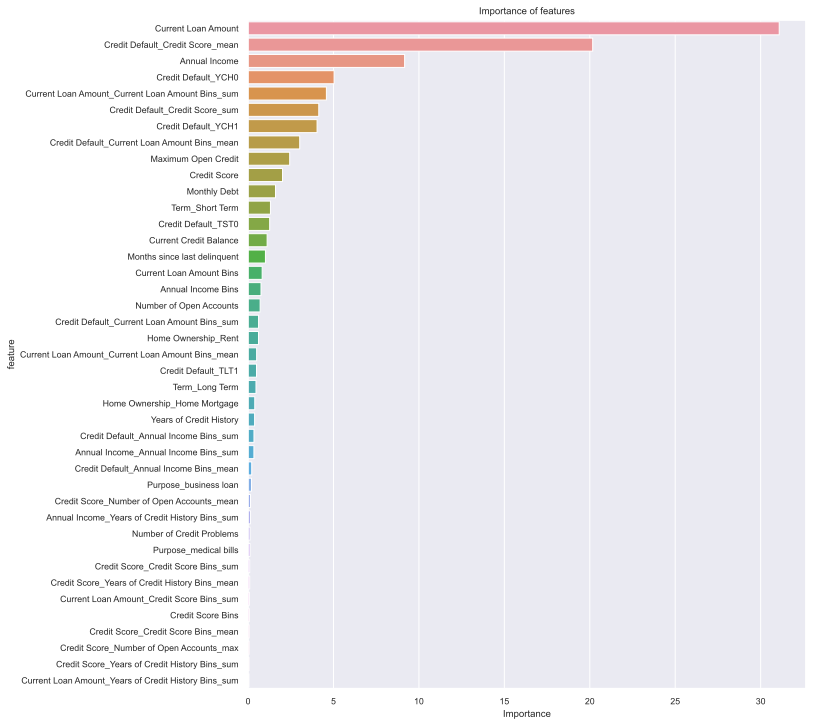

In [146]:
feature_importances = pd.DataFrame({'feature': X_train.columns,
                                   'importance': final_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize = (10, len(feature_importances) * 0.3))

sns.barplot(feature_importances['importance'], feature_importances['feature'])

plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()